In [261]:
import rasterio as rio
from rasterio.merge import merge
import matplotlib.pyplot as plt
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import os
from pysheds.grid import Grid

In [262]:
# Set the working directory
path = "D:\\Fall2024\GIS\\DEMs"
os.chdir(path)

<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\User\AppData\Local\Temp\ipykernel_26744\1546923926.py:2: SyntaxWarning: invalid escape sequence '\G'
  path = "D:\\Fall2024\GIS\\DEMs"


In [263]:
# Make list of each Bills files to read
bil_files = ["n29_w094_1arc_v2.bil","n29_w095_1arc_v2.bil","n30_w094_1arc_v2.bil","n30_w095_1arc_v2.bil"]

In [264]:
# Open each file and add List of datasets
data =  [rio.open(file) for file in bil_files]

Merging and Saving DEMS

In [ ]:
# Merge the datasets
mosaic, out_transform = merge(data)

# Get metadata from the first dataset to use for the output

out_meta = data[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

#Save the merged DEM
with rio.open('mosaicresults.tif', 'w', **out_meta) as dest: dest.write(mosaic)

In [268]:
# Open the raster file
Myraster = "D:\\Fall2024\GIS\\DEMs\\mosaicresults.tif"
with rio.open(Myraster) as src:
    data2 = src.read(1)
    metadata = src.profile
    print("Metadata:", metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 7201, 'height': 7201, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000277777777777778, 0.0, -95.00013888888888,
       0.0, -0.000277777777777778, 31.000138888888888), 'blockxsize': 7201, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\User\AppData\Local\Temp\ipykernel_26744\924910137.py:2: SyntaxWarning: invalid escape sequence '\G'
  Myraster = "D:\\Fall2024\GIS\\DEMs\\mosaicresults.tif"


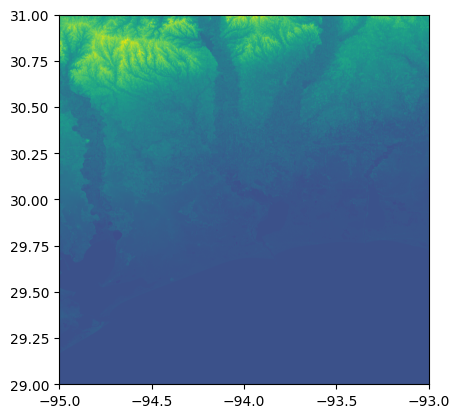

In [269]:
from rasterio.plot import show

# Open your raster file
with rasterio.open('mosaicresults.tif') as src:
    show(src)

Using the Beaumont City plolygon and the Merged DEMS to find the lowest Elevation within the city 
limits.

In [270]:
# Load the vector file (city limits)
Beaumont = gpd.read_file('Beaumont.gpkg')

# Load the merged DEM file
demm = rio.open('mosaicresults.tif')

In [271]:
# Clip the DEM using the city limits
Beaumontgeom = [Beaumont.geometry.union_all()]
clipped_dem, clipped_transform = mask(demm, Beaumontgeom, crop=True)

In [272]:
# Define the output path for the clipped DEM
output_clipped_dem_path = 'clipped_dem.tif'

# Save the masked DEM
with rio.open(output_clipped_dem_path, 'w', driver='GTiff', 
                   height=clipped_dem.shape[1], width=clipped_dem.shape[2], 
                   count=1, dtype=clipped_dem.dtype, crs=dem.crs, 
                   transform=clipped_transform) as dst:
    dst.write(clipped_dem[0], 1)

In [274]:
# Convert the masked DEM to float type
clipped_dem = clipped_dem.astype(float)

# Identify no data values in the clipped DEM
no_data_value = dem.nodata
clipped_dem[clipped_dem == no_data_value] = np.nan

# Find the minimum elevation, ignoring no data values
min_elevation = np.nanmin(clipped_dem)
print(f'The lowest elevation within the city limits is {min_elevation} meters.')

The lowest elevation within the city limits is -32.0 meters.


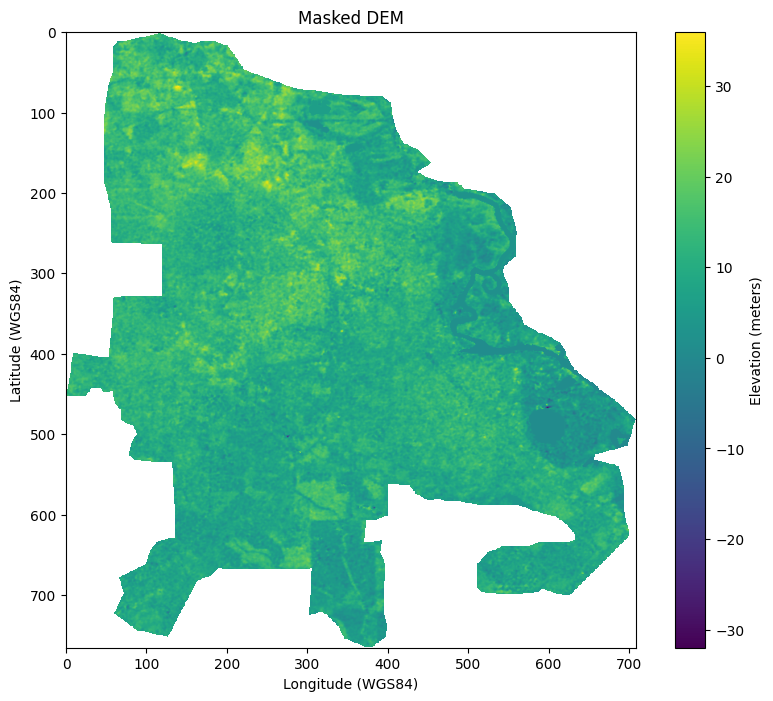

In [277]:
# Plot the clipped DEM
plt.figure(figsize=(10, 8))
plt.imshow(clipped_dem[0], cmap='viridis')
plt.colorbar(label='Elevation (meters)')
plt.title('Masked DEM')
plt.xlabel('Longitude (WGS84)')
plt.ylabel('Latitude (WGS84)')
plt.show()

Updating and Saving the Masked DEM

In [278]:
# Define the file path for the new DEM
output_path = 'D:\\Fall2024\\GIS\\DEMs\\modified_clipped_dem.tif'

# Get the metadata of the original DEM
with rio.open('clipped_dem.tif') as src:
    meta = src.meta

# Update the metadata to reflect the changes
meta.update(dtype=rio.float32, nodata=np.nan)

# Ensure the clipped_dem array has the correct shape
if clipped_dem.ndim == 3 and clipped_dem.shape[0] == 1:
    clipped_dem = clipped_dem.squeeze(axis=0)

# Save the modified DEM
with rio.open(output_path, 'w', **meta) as dst:
    dst.write(clipped_dem.astype(rasterio.float32), 1)

print(f'Modified DEM saved to {output_path}')

Modified DEM saved to D:\Fall2024\GIS\DEMs\modified_clipped_dem.tif


Intializing Grid

In [298]:
# Initialize the grid from the raster
grid = Grid.from_raster("mosaicresults.tif", data_name="dem")
# Check if the data is a Raster instance
print(isinstance(demdata, Raster))  # Should return True if it is a Raster instance

True


In [309]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

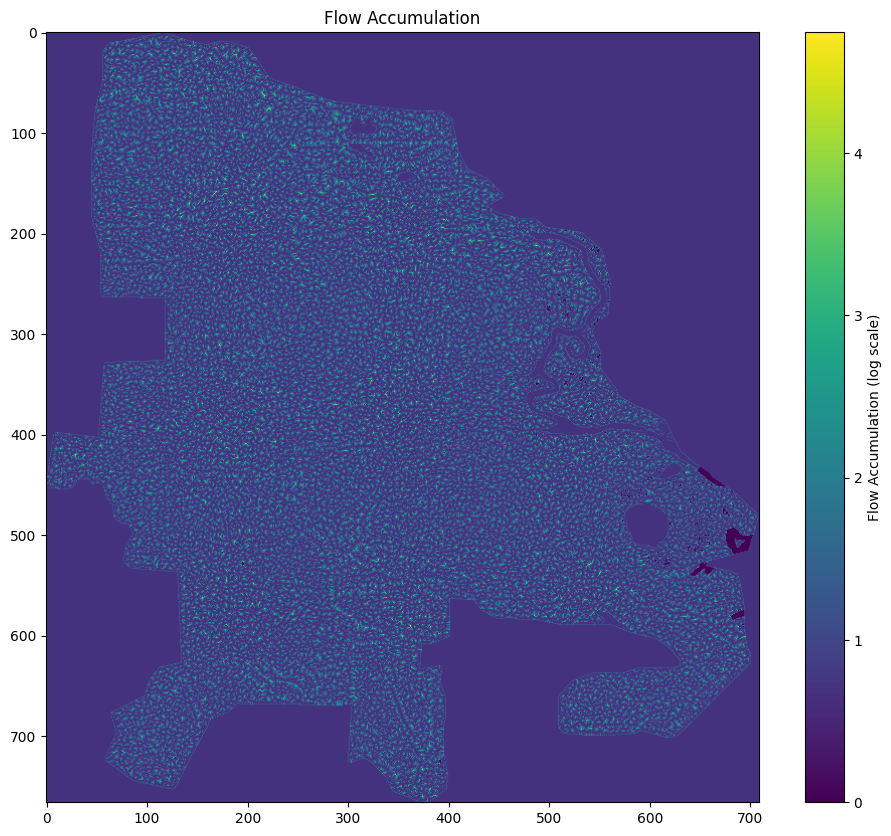

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [310]:
# Plot the flow accumulation
plt.figure(figsize=(12, 10))
plt.imshow(np.log1p(flow_accum), cmap='viridis')
plt.colorbar(label='Flow Accumulation (log scale)')
plt.title('Flow Accumulation')
plt.show()
print(flow_accum)

In [306]:
# Manually select Pour points
x, y =-94.2276,30.1871

In [307]:
# Delineate the watershed with additional parameters
watershed = grid.catchment(fdir=flow_direction, x=x, y=y, dirmap=dirmap, out_name='catch',
                           recursionlimit=15000, xytype='label', nodata_out=-9999)

TypeError: `nodata` value not representable in dtype of array.